# Admin

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from scipy.optimize import curve_fit
from tqdm.auto import trange
from tqdm import tqdm
import Metropolis_Algorithm as MA

import importlib

importlib.reload(MA)

# Setting Constants
x_0 = 0
y_0 = 0
t_i = 0
t_f = 8

mass = 1
steps = 150  # Reduced from 800 - fewer points to update
numb_paths = 1000

times = np.linspace(t_i, t_f, steps)
dt = times[1] - times[0]

C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Potential
def x_potential(x):
    return 1/2 * x**2

def y_potential(x):
    return 1000 * x**4

def ho_analytic_pdf(x):
    return (1 / np.sqrt(np.pi)) * np.exp(-x**2)

def residual_calculator(x_values, model, model_parameters, y_values, y_errors):
    theoretical_values = model(x_values, *model_parameters)
    residuals = (y_values - theoretical_values)/y_errors
    return residuals

# PIMC Run Algorithm

In [3]:
def run_path_integral(
    potential,
    *,
    analytic_pdf=None,
    x0=0.0,
    xN=0.0,
    t_i=0.0,
    t_f=8.0,
    mass=1.0,
    steps=150,
    numb_paths=1000,
    C=2.5,
    n_therm=500,
    n_sample=5000,
    thin=10,
    n_interior_updates=5,
    bins=np.linspace(-2, 2, 201),
    plot=False,
    title="Ground State Wavefunction",
    verbose=True,
):
    """
    Full path-integral Metropolis simulation with optional plotting.
    """

    # --- Time grid ---
    times = np.linspace(t_i, t_f, steps)
    dt = times[1] - times[0]
    sigma_prop = C * np.sqrt(dt)

    # --- Initialise paths ---
    paths = np.array([
        MA.Pos_Gen(x0, xN, steps, dt)
        for _ in range(numb_paths)
    ])

    # --- Thermalisation ---
    if verbose:
        print("Thermalising...")

    for _ in trange(n_therm, disable=not verbose):
        acc_int, acc_end = MA.metropolis_sweep_vectorised(
            paths, times, mass, potential, sigma_prop,
            n_interior_updates=n_interior_updates
        )

    # --- Sampling ---
    samples = []

    if verbose:
        print("Sampling...")

    for sweep in trange(n_sample, disable=not verbose):
        acc_int, acc_end = MA.metropolis_sweep_vectorised(
            paths, times, mass, potential, sigma_prop,
            n_interior_updates=n_interior_updates
        )

        if sweep % thin == 0:
            samples.append(paths[:, -1].copy())

    samples = np.concatenate(samples)

    # --- PDF ---
    hist, edges = np.histogram(samples, bins=bins)
    centres = 0.5 * (edges[1:] + edges[:-1])
    dx = centres[1] - centres[0]
    pdf = hist / np.sum(hist * dx)

    # --- Reduced chi-squared (if analytic provided) ---
    chi2_red = None

    if analytic_pdf is not None:
        analytic_vals = analytic_pdf(centres)
        analytic_vals /= np.sum(analytic_vals * dx)

        # Poisson errors on histogram
        errors = np.sqrt(hist) / (np.sum(hist) * dx)

        # Avoid division by zero
        mask = errors > 0

        chi2 = np.sum(
            (pdf[mask] - analytic_vals[mask])**2 / errors[mask]**2
        )

        dof = np.sum(mask)  # no fitted parameters
        chi2_red = chi2 / dof


    # --- Statistics ---
    rms = np.sqrt(np.mean(samples**2))
    std = np.std(samples)

    diagnostics = {
        "rms": rms,
        "std": std,
        "endpoint_acceptance": acc_end,
        "interior_acceptance": acc_int,
        "n_samples": len(samples),
        "chi2_red": chi2_red,
    }


    # --- Plot ---
    if plot:
        plt.figure(figsize=(10, 6))
        plt.scatter(
            centres, pdf,
            s=10, alpha=0.6, color='grey',
            label='Path integral estimate'
        )

        if analytic_pdf is not None:
            analytic_vals = analytic_pdf(centres)
            analytic_vals /= np.sum(analytic_vals * dx)
            plt.plot(
                centres, analytic_vals,
                'k--', linewidth=2,
                label='Analytic'
            )

        plt.xlabel('x', fontsize=12)
        plt.ylabel('Probability density', fontsize=12)
        plt.title(title)
        plt.legend(fontsize=11)
        plt.tight_layout()
        plt.show()

    return centres, pdf, samples, diagnostics


# Sampling Example

Thermalizing...


Thermalising:  22%|██▏       | 110/500 [00:00<00:00, 525.70it/s]

Endpoint acceptance ≈ 0.427
Endpoint acceptance ≈ 0.413


Thermalising:  64%|██████▍   | 322/500 [00:00<00:00, 622.17it/s]

Endpoint acceptance ≈ 0.426
Endpoint acceptance ≈ 0.430


Thermalising: 100%|██████████| 500/500 [00:00<00:00, 590.21it/s]


Endpoint acceptance ≈ 0.410

Sampling...


Sampling:   0%|          | 19/5000 [00:00<00:07, 623.31it/s]

Endpoint acceptance ≈ 0.413


Sampling:   2%|▏         | 119/5000 [00:00<00:07, 686.27it/s]

Endpoint acceptance ≈ 0.437


Sampling:   4%|▍         | 214/5000 [00:00<00:08, 538.35it/s]

Endpoint acceptance ≈ 0.433


Sampling:   6%|▌         | 302/5000 [00:00<00:11, 417.48it/s]

Endpoint acceptance ≈ 0.440


Sampling:  10%|█         | 514/5000 [00:00<00:07, 584.88it/s]

Endpoint acceptance ≈ 0.388
Endpoint acceptance ≈ 0.426


Sampling:  14%|█▍        | 720/5000 [00:01<00:08, 530.34it/s]

Endpoint acceptance ≈ 0.418
Endpoint acceptance ≈ 0.437


Sampling:  18%|█▊        | 925/5000 [00:01<00:06, 637.28it/s]

Endpoint acceptance ≈ 0.428
Endpoint acceptance ≈ 0.409


Sampling:  22%|██▏       | 1121/5000 [00:01<00:06, 631.17it/s]

Endpoint acceptance ≈ 0.414
Endpoint acceptance ≈ 0.407


Sampling:  26%|██▋       | 1321/5000 [00:02<00:05, 638.02it/s]

Endpoint acceptance ≈ 0.393
Endpoint acceptance ≈ 0.430


Sampling:  30%|███       | 1520/5000 [00:02<00:07, 451.92it/s]

Endpoint acceptance ≈ 0.419
Endpoint acceptance ≈ 0.420


Sampling:  34%|███▍      | 1717/5000 [00:03<00:05, 588.62it/s]

Endpoint acceptance ≈ 0.418
Endpoint acceptance ≈ 0.426


Sampling:  38%|███▊      | 1910/5000 [00:03<00:06, 497.28it/s]

Endpoint acceptance ≈ 0.440
Endpoint acceptance ≈ 0.397


Sampling:  42%|████▏     | 2113/5000 [00:03<00:05, 541.77it/s]

Endpoint acceptance ≈ 0.434
Endpoint acceptance ≈ 0.419


Sampling:  46%|████▋     | 2313/5000 [00:04<00:04, 650.07it/s]

Endpoint acceptance ≈ 0.447
Endpoint acceptance ≈ 0.474


Sampling:  50%|█████     | 2513/5000 [00:04<00:04, 523.94it/s]

Endpoint acceptance ≈ 0.416
Endpoint acceptance ≈ 0.429


Sampling:  54%|█████▍    | 2713/5000 [00:04<00:03, 608.16it/s]

Endpoint acceptance ≈ 0.410
Endpoint acceptance ≈ 0.439


Sampling:  58%|█████▊    | 2914/5000 [00:05<00:04, 507.65it/s]

Endpoint acceptance ≈ 0.416
Endpoint acceptance ≈ 0.434


Sampling:  62%|██████▏   | 3111/5000 [00:05<00:03, 565.29it/s]

Endpoint acceptance ≈ 0.440
Endpoint acceptance ≈ 0.432


Sampling:  66%|██████▋   | 3315/5000 [00:05<00:02, 656.94it/s]

Endpoint acceptance ≈ 0.434
Endpoint acceptance ≈ 0.412


Sampling:  70%|███████   | 3514/5000 [00:06<00:02, 578.77it/s]

Endpoint acceptance ≈ 0.416
Endpoint acceptance ≈ 0.414


Sampling:  74%|███████▍  | 3722/5000 [00:06<00:01, 697.53it/s]

Endpoint acceptance ≈ 0.443
Endpoint acceptance ≈ 0.459


Sampling:  78%|███████▊  | 3921/5000 [00:06<00:01, 617.14it/s]

Endpoint acceptance ≈ 0.414
Endpoint acceptance ≈ 0.469


Sampling:  82%|████████▏ | 4113/5000 [00:07<00:01, 512.46it/s]

Endpoint acceptance ≈ 0.416
Endpoint acceptance ≈ 0.416


Sampling:  86%|████████▋ | 4319/5000 [00:07<00:01, 646.41it/s]

Endpoint acceptance ≈ 0.441
Endpoint acceptance ≈ 0.455


Sampling:  90%|█████████ | 4517/5000 [00:07<00:00, 627.01it/s]

Endpoint acceptance ≈ 0.426
Endpoint acceptance ≈ 0.426


Sampling:  94%|█████████▍| 4716/5000 [00:08<00:00, 624.16it/s]

Endpoint acceptance ≈ 0.433
Endpoint acceptance ≈ 0.439


Sampling:  98%|█████████▊| 4920/5000 [00:08<00:00, 613.10it/s]

Endpoint acceptance ≈ 0.441
Endpoint acceptance ≈ 0.448


Sampling: 100%|██████████| 5000/5000 [00:08<00:00, 574.34it/s]



------ Results ------
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000
Standard deviation: 0.6991 (expected ≈ 0.707)
Root mean square: 0.6991 (expected ≈ 0.707)


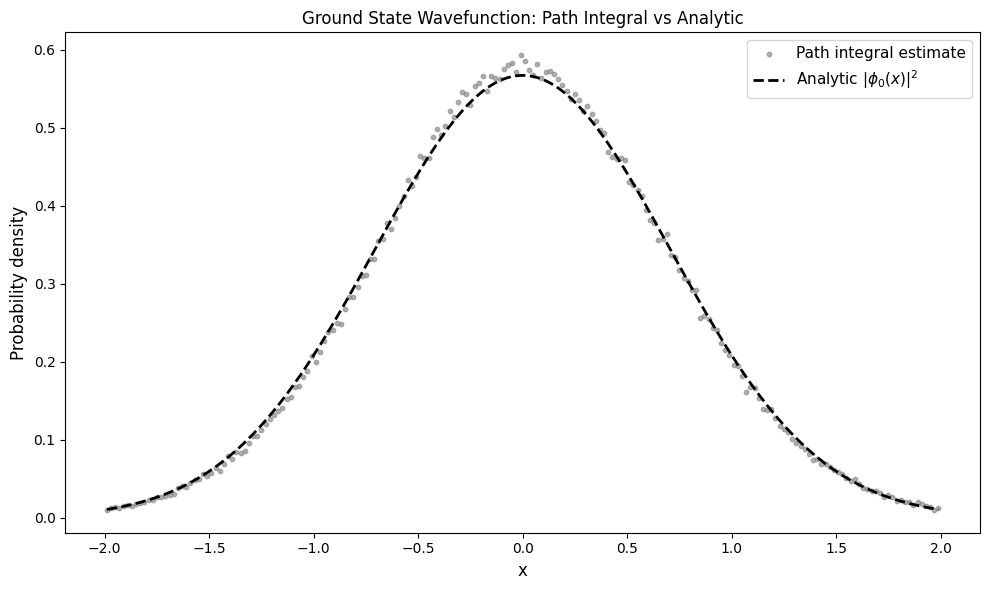

In [4]:
# Initialize paths (Brownian bridge from 0 to 0)
paths_x = np.array([
    MA.Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

C = 2.5
mid = paths_x.shape[1] // 2
thin = 10
sigma_prop = C * np.sqrt(dt)

# Thermalization
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = MA.metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if sweep % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

# Sampling
print("\nSampling...")
samples_x = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = MA.metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if k % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

    if k % thin == 0:
        samples_x.append(paths_x[:, -1].copy())

samples_x = np.concatenate(samples_x)

# Compute PDF
x_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_x, bin_edges_x = np.histogram(samples_x, bins=x_bins)

x_centres = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
dx = np.diff(x_bins)[0]

pdf_x = pdf_unnormalised_x / np.sum(pdf_unnormalised_x * dx)

# Analytic PDF
phi_sq_analytic_x = (1 / np.sqrt(np.pi)) * np.exp(-x_centres ** 2)
phi_sq_analytic_x /= np.sum(phi_sq_analytic_x * dx)

# Statistics
mean_square_x = np.mean(samples_x**2)
rms = np.sqrt(mean_square_x)
std = np.std(samples_x)

print("\n------ Results ------")
print(f"Numerical PDF area: {np.sum(pdf_x * dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_x * dx):.5f}")
print(f"Standard deviation: {std:.4f} (expected ≈ 0.707)")
print(f"Root mean square: {rms:.4f} (expected ≈ 0.707)")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_centres, pdf_x, label='Path integral estimate', s=10, alpha=0.6, color = 'grey')
plt.plot(x_centres, phi_sq_analytic_x, 'black',linestyle = '--', linewidth=2, label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(fontsize=11)
plt.title('Ground State Wavefunction: Path Integral vs Analytic')

plt.tight_layout()
plt.show()

Thermalising...


100%|██████████| 500/500 [00:00<00:00, 1403.89it/s]


Sampling...


100%|██████████| 5000/5000 [00:03<00:00, 1437.08it/s]


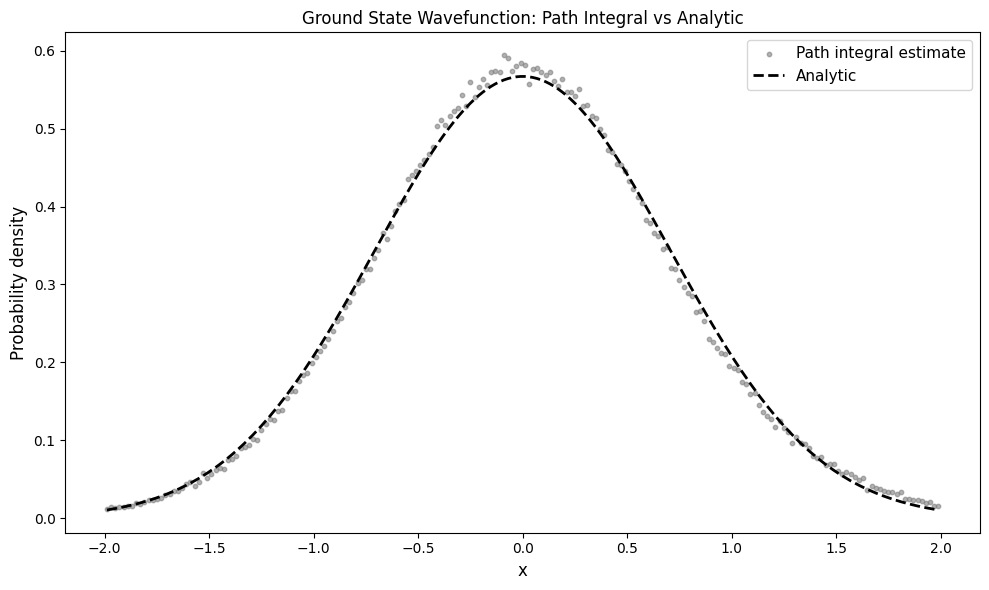

{'rms': np.float64(0.7108250849174584), 'std': np.float64(0.7108145242509463), 'endpoint_acceptance': np.float64(0.42), 'interior_acceptance': np.float64(0.33199999999999996), 'n_samples': 500000, 'chi2_red': np.float64(5.535188111364423)}


In [5]:
centres, pdf, samples, diag = run_path_integral(
    x_potential,
    analytic_pdf=ho_analytic_pdf,
    plot=True,
    title="Ground State Wavefunction: Path Integral vs Analytic",
)

print(diag)

# Steps Optimisation

In [6]:
C_opt = 1.9486730473563159

def rms_error_steps(n_steps, n_rep=5):
    values = []

    for _ in range(n_rep):
        _, _, _, diag = run_path_integral(
            x_potential,
            C=C_opt,                 # already optimised
            steps=int(n_steps),
            verbose=False,
            n_sample=3000,
            n_therm=300,
        )
        values.append(abs(diag["rms"] - 1/np.sqrt(2)))

    values = np.array(values)

    mean = np.mean(values)
    std = np.std(values, ddof=1)
    stderr = std / np.sqrt(n_rep)

    return mean, stderr

steps_values = np.unique(
    np.logspace(np.log10(30), np.log10(400), 15).astype(int)
)

print(steps_values[8])

131


In [7]:
steps_mean = []
steps_stderr = []

for n_steps in tqdm(steps_values, desc="Scanning steps"):
    mean, stderr = rms_error_steps(n_steps, n_rep=5)
    steps_mean.append(mean)
    steps_stderr.append(stderr)

steps_mean = np.array(steps_mean)
steps_stderr = np.array(steps_stderr)


Scanning steps: 100%|██████████| 15/15 [03:20<00:00, 13.37s/it]


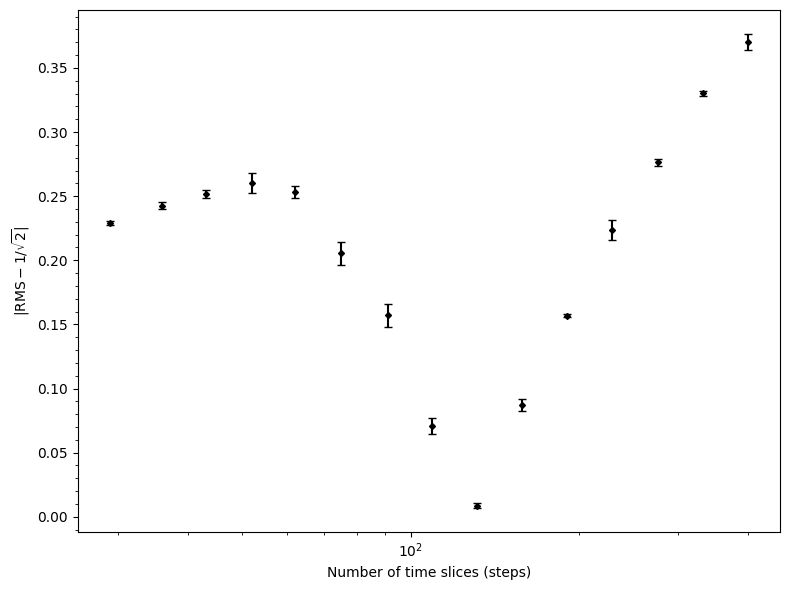

In [8]:
plt.figure(figsize=(8,6))

plt.errorbar(
    steps_values,
    steps_mean,
    yerr=steps_stderr,
    fmt='D',
    color='black',
    markersize = 3,
    capsize=3
)

plt.xscale('log')
plt.xlabel("Number of time slices (steps)")
plt.ylabel(r"$| \mathrm{RMS} - 1/\sqrt{2} |$")
plt.minorticks_on()

plt.tight_layout()
plt.show()


In [9]:
steps_fine = np.arange(100, 170, 5)

steps_mean_fine = []
steps_stderr_fine = []

for n_steps in tqdm(steps_fine, desc="Scanning steps"):
    mean, stderr = rms_error_steps(n_steps, n_rep=5)
    steps_mean_fine.append(mean)
    steps_stderr_fine.append(stderr)

steps_mean_fine = np.array(steps_mean_fine)
steps_stderr_fine = np.array(steps_stderr_fine)

Scanning steps: 100%|██████████| 14/14 [03:05<00:00, 13.23s/it]


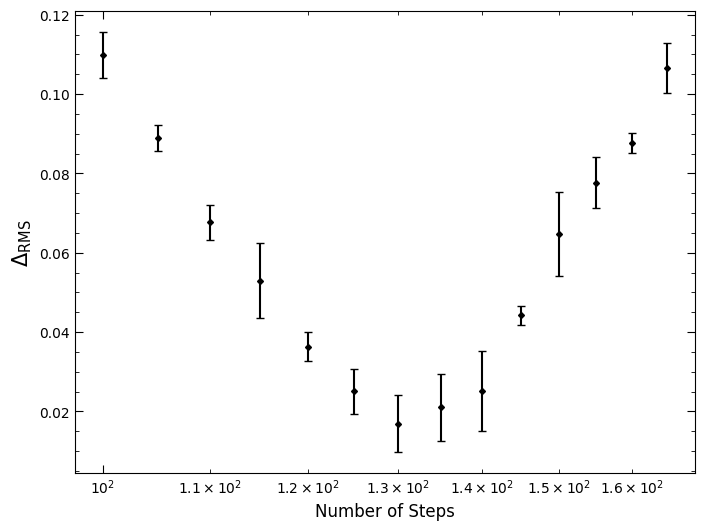

The optimised number of steps is 130


In [10]:
pc_savepath_Nsteps_opt = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\N_steps_optimisation.svg"

plt.figure(figsize=(8, 6))

plt.errorbar(
    steps_fine,
    steps_mean_fine,
    yerr=steps_stderr_fine,
    fmt='D',
    color='black',
    markersize=3,
    capsize=3
)

plt.xscale('log')
plt.xlabel("Number of Steps", fontsize=12)
plt.ylabel(r"$\Delta_\text{RMS}$", fontsize=15)
plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')


plt.savefig(pc_savepath_Nsteps_opt, bbox_inches = 'tight')
plt.show()

print(f"The optimised number of steps is {steps_fine[6]}")

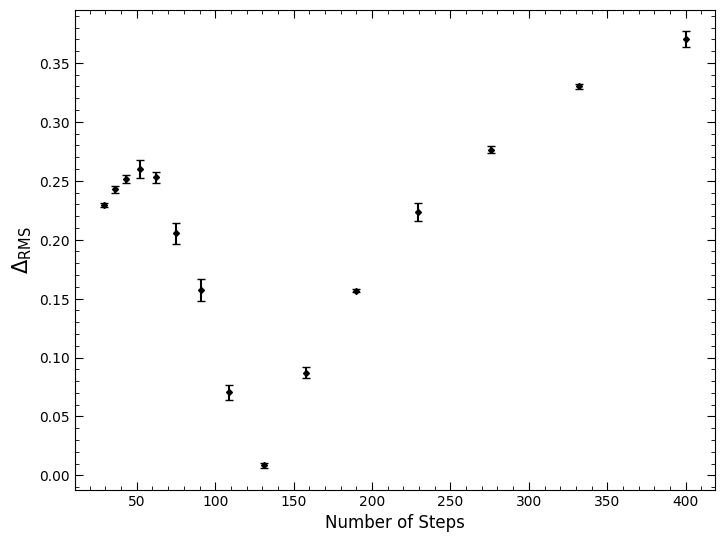

In [11]:
#combined plot
pc_savepath_combined_Nsteps = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\Combined_Nsteps.svg"

fig = plt.figure(1)

plt1 = fig.add_axes([0,0,1,1])

plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

plt.errorbar(
    steps_values,
    steps_mean,
    yerr=steps_stderr,
    fmt='D',
    color='black',
    markersize = 3,
    capsize=3
)

plt.xlabel("Number of Steps", fontsize=12)
plt.ylabel(r"$\Delta_\text{RMS}$", fontsize=15)

plt.savefig(pc_savepath_combined_Nsteps, bbox_inches = 'tight')
plt.show()

# Optimising C

In [12]:
def rms_error(C):
    _, _, _, diag = run_path_integral(
        x_potential,
        C=C,
        verbose=False,
        n_sample=3000,
        n_therm=300,
    )
    return abs(diag["rms"] - 1/np.sqrt(2))

def rms_error_replicated(C, n_rep=5):
    values = []

    for _ in range(n_rep):
        _, _, _, diag = run_path_integral(
            x_potential,
            C=C,
            verbose=False,
            n_sample=3000,
            n_therm=300,
        )
        values.append(abs(diag["rms"] - 1/np.sqrt(2)))

    values = np.array(values)

    mean = np.mean(values)
    std = np.std(values, ddof=1)          # unbiased
    stderr = std / np.sqrt(n_rep)

    return mean, stderr

Cs = np.linspace(1.0, 4.0, 20)

Cs_mean = []
Cs_stderr = []

for C in tqdm(Cs, desc="Scanning C"):
    mean, stderr = rms_error_replicated(C, n_rep=10)
    Cs_mean.append(mean)
    Cs_stderr.append(stderr)

Scanning C: 100%|██████████| 20/20 [08:59<00:00, 27.00s/it]


In [13]:
Cs_data = np.array(Cs)
Cs_RMS_diff = np.array(Cs_mean)
Cs_RMS_error = np.array(Cs_stderr)

print(Cs_data)
print(len(Cs_data))

print(Cs_RMS_diff)
print(len(Cs_RMS_diff))

print(Cs_RMS_error)
print(len(Cs_RMS_error))

[1.         1.15789474 1.31578947 1.47368421 1.63157895 1.78947368
 1.94736842 2.10526316 2.26315789 2.42105263 2.57894737 2.73684211
 2.89473684 3.05263158 3.21052632 3.36842105 3.52631579 3.68421053
 3.84210526 4.        ]
20
[0.08588212 0.06853378 0.08266888 0.06643198 0.05432923 0.05703891
 0.05143701 0.06043916 0.05946935 0.06807054 0.07689822 0.07598816
 0.07844594 0.08418508 0.08768936 0.08743277 0.09254485 0.09572076
 0.10197822 0.10220517]
20
[0.00370108 0.00392576 0.00544193 0.00359175 0.00241013 0.00564848
 0.00487771 0.00339157 0.00313147 0.00355072 0.0035465  0.0023467
 0.00290837 0.0029069  0.00342978 0.0041872  0.00449662 0.00375236
 0.00396058 0.00243516]
20


In [14]:
def C_polynomial(x,A,x0, C):
    return A*(x-x0)**2 + C

p0_C_polynomial = [1, #A
      2, #x0
      0.1] #C

popt_C_opt, cov_C_opt = curve_fit(C_polynomial,
                                  xdata= Cs_data,
                                  ydata = Cs_RMS_diff,
                                  sigma= Cs_RMS_error,
                                  absolute_sigma= True,
                                  p0 = p0_C_polynomial)

In [15]:
#finding residuals

Cs_residuals = residual_calculator(x_values= Cs_data,
                                   model= C_polynomial,
                                   model_parameters= popt_C_opt,
                                   y_values= Cs_RMS_diff,
                                   y_errors = Cs_RMS_error)

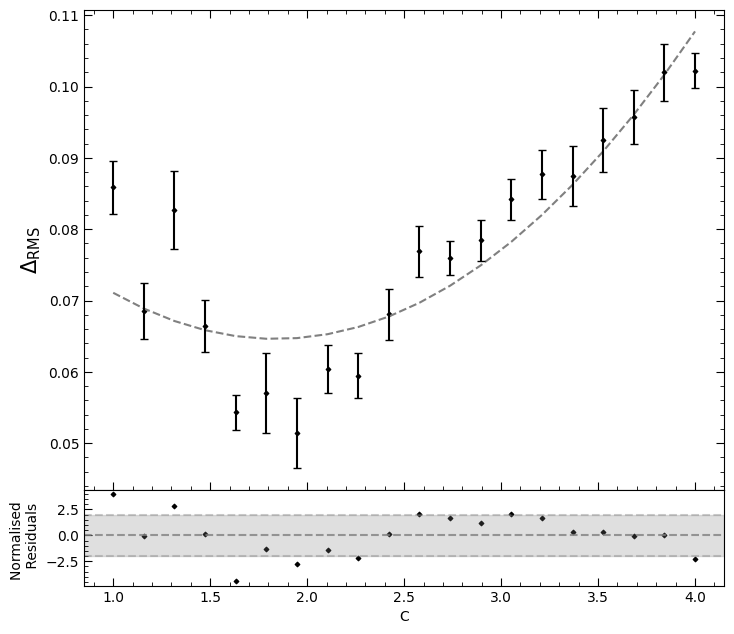

The optimised C value is 1.8375762569452279


In [16]:
pc_savepath_C_optimisation = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\c_optimisation.svg"

fig = plt.figure(1)

#main plot
fig.add_axes([0,0,1,1])
plt.scatter(Cs_data, Cs_RMS_diff, color = 'black', marker = 'D', s = 5)
plt.plot(Cs_data, C_polynomial(Cs_data, popt_C_opt[0], popt_C_opt[1], popt_C_opt[2]), linestyle = '--', color = 'grey')
plt.errorbar(Cs_data, Cs_RMS_diff, yerr= Cs_RMS_error, fmt= 'none', color = 'black', capsize = 3)

plt.ylabel(r"$\Delta_\text{RMS}$", fontsize=15)
plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

#residual plot
rp = fig.add_axes([0,-0.2,1,0.2])

rp.scatter(Cs_data, Cs_residuals, color = 'black', marker = 'D', s = 5)

rp.axhline(0, color = 'grey', alpha = 0.8, linestyle = '--')
rp.axhline(np.std(Cs_residuals), color = 'grey', alpha = 0.4, linestyle = '--')
rp.axhline(-np.std(Cs_residuals), color = 'grey', alpha = 0.4, linestyle = '--')
# Fill horizontal band from y=-1 to y=1, across full axes width
rp.axhspan(-np.std(Cs_residuals), np.std(Cs_residuals), color='grey', alpha=0.25)

rp.set_ylabel("Normalised \n Residuals")
rp.set_xlabel("C")
rp.minorticks_on()
rp.tick_params(which = 'major', length = 6, bottom = True, top = False, left = True, right = False, direction = 'in')
rp.tick_params(which = 'minor', length = 3, bottom = True, top = False, left = True, right = False, direction = 'in')

plt.savefig(pc_savepath_C_optimisation,bbox_inches='tight')

plt.show()

print(f"The optimised C value is {popt_C_opt[1]}")

# Thin Optimisation

In [9]:
endpoint_chain = []

for sweep in trange(5000):
    acc_int, acc_end = MA.metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop,
        n_interior_updates=5
    )
    endpoint_chain.append(paths_x[0, -1])

100%|██████████| 5000/5000 [00:03<00:00, 1468.72it/s]


In [10]:
def autocorr(x):
    x = np.asarray(x)
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:] / result[result.size // 2]

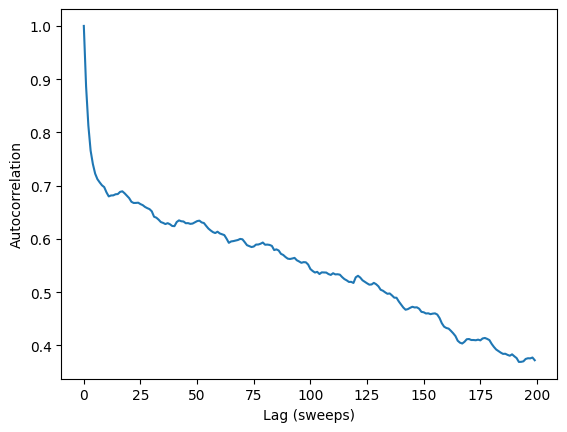

In [11]:
acf = autocorr(endpoint_chain)

plt.plot(acf[:200])
plt.xlabel("Lag (sweeps)")
plt.ylabel("Autocorrelation")
plt.show()


In [12]:
def integrated_autocorr_time(acf, cutoff=0.01):
    positive = acf > cutoff
    return 0.5 + np.sum(acf[1:][positive[1:]])

tau_int = integrated_autocorr_time(acf)
print(f"Integrated autocorrelation time ≈ {tau_int:.1f} sweeps")

Integrated autocorrelation time ≈ 330.4 sweeps


In [13]:
thin_opt = int(np.ceil(2 * tau_int))

In [15]:
numb_paths = 1

paths_test = np.array([
    MA.Pos_Gen(0.0, 0.0, steps, dt)
])

endpoint_chain = []

for sweep in trange(5000):
    MA.metropolis_sweep_vectorised(
        paths_test, times, mass, x_potential, sigma_prop,
        n_interior_updates=5
    )
    endpoint_chain.append(paths_test[0, -1])


100%|██████████| 5000/5000 [00:01<00:00, 3185.26it/s]


In [16]:
acf = autocorr(endpoint_chain)
tau_int = integrated_autocorr_time(acf)
print(tau_int)

187.417086392508


In [18]:
rms_chain = []

paths_test = np.array([
    MA.Pos_Gen(0.0, 0.0, steps, dt)
])

for sweep in trange(5000):
    MA.metropolis_sweep_vectorised(
        paths_test, times, mass, x_potential, sigma_prop,
        n_interior_updates=5
    )
    rms_chain.append(np.sqrt(np.mean(paths_test[:, -1]**2)))

100%|██████████| 5000/5000 [00:01<00:00, 3148.68it/s]


In [19]:
acf_rms = autocorr(rms_chain)
tau_int_rms = integrated_autocorr_time(acf_rms)
print(tau_int_rms)

228.72146611929182


In [20]:
rms_chain = []

for sweep in trange(5000):
    MA.metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop,
        n_interior_updates=5
    )
    rms_chain.append(np.sqrt(np.mean(paths_x[:, -1]**2)))


100%|██████████| 5000/5000 [00:03<00:00, 1454.74it/s]


In [21]:
acf_rms = autocorr(rms_chain)
tau_int_rms = integrated_autocorr_time(acf_rms)
print(tau_int_rms)

548.0277205973254
